Finetune the BERT on the 3 data variations:
- Original data: Fine-tune using original_train.csv.
- Neutral data: Fine-tune using neutral_train.csv.
- Balanced (mix) data: Fine-tune using mix_train.csv.

In the end, I'll have 3 finetuned models
- One trained on the original data
- One trained on the neutral data
- One trained on the balanced (mix) data


...

After finetuning, the next step is to test each of these models.

In [34]:
import os
import sys
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForTokenClassification, AutoModelForSequenceClassification
from collections import Counter
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [36]:
# Function to compute the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(preds_flat == labels_flat) / len(labels_flat)


In [38]:
def load_data(file_path):
    """
    Loads data and converts Sentiment classes to numeric labels (1 for positive, 0 for negative).
    """

    df = pd.read_csv(file_path)
    df['Sentiment'] = df['Sentiment'].map({'pos': 1, 'neg': 0})
    
    df = df[:10]

    text = df['text'].tolist()
    labels = df['Sentiment'].tolist()

    return text, labels

In [39]:
train_file = '/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/original_train.csv'
train_text, train_labels = load_data(train_file)

print(train_text[:3])
print(train_labels[:3])
print(len(train_labels))
print(Counter(train_labels)) # Counter({0: 978, 1: 921}) = almost equally balanced

['handskerne passer ikke det var det tvivlsomme argument hvormed forsvareren vandt retssagen mod oj simpson i 1995 den verdenskendte fodboldstjerne og skuespiller var anklaget for mordet på sin ekskone og hendes ven og selv om sagen bugnede med beviser imod ham blev oj simpson frikendt historien fortælles med bravur i den første sæson af antologitvserienamerican crime story der for hver sæson fortæller en stor kriminalhistorie fra virkeligheden første sæson har undertitlenthe people v oj simpson og i første afsnit finder politiet i los angeles de myrdede nicole simpson og ronald goldman alle spor fører hjem til oj simpsons hus simpson cuba gooding jr går i panik og hele andet afsnit viser den tossede biljagt hvor han på vej hjem til sin mor bliver fulgt af en horde af politibiler og nyhedshelikoptere mens han over telefon truer både medier og sine venner med at begå selvmord herfra bliver serien et retssalsdrama men sikke et drama oj simpson har et imponerende hold af superadvokater ba

In [40]:
# Load Danish BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vesteinn/DanskBERT")
tokenizer

XLMRobertaTokenizerFast(name_or_path='vesteinn/DanskBERT', vocab_size=50005, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50004: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [41]:
# Tokenize data
input_ids = []
attention_masks = []

for text in train_text:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 512,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt",
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [42]:
# Convert to tensors
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(train_labels)

print(input_ids)
print(attention_masks)
print(labels)

tensor([[    0,   733, 13124,  ..., 11425,    33,     2],
        [    0, 24338,    59,  ..., 42074,   471,     2],
        [    0,    13,  7258,  ...,  1506,   330,     2],
        ...,
        [    0,    82, 36160,  ...,  1533, 22028,     2],
        [    0,    37,   273,  ...,  1133,   345,     2],
        [    0, 34860,   413,  ...,    99,    45,     2]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 1])


In [43]:
# Create dataset
dataset = TensorDataset(input_ids, attention_masks, labels)
dataset[:5]

(tensor([[    0,   733, 13124,  ..., 11425,    33,     2],
         [    0, 24338,    59,  ..., 42074,   471,     2],
         [    0,    13,  7258,  ...,  1506,   330,     2],
         [    0,    82, 21619,  ..., 39247,    33,     2],
         [    0,    97,   711,  ..., 19069,  7634,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([1, 1, 1, 0, 0]))

In [44]:
# Create a 80-20 train-validation split

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Create the 80-20 train-validation split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"{train_size:,} training samples")
print(f"{val_size:,} validation samples")


###
# could be an idea to test on different split
###

9 training samples
1 validation samples


In [45]:
# DataLoader

batch_size = 8  # 16, 32, 8

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

validation_dataloader = DataLoader(val_dataset, batch_size = batch_size)

In [46]:
# Load Danish BERT model

model = AutoModelForSequenceClassification.from_pretrained(
    "vesteinn/DanskBERT",
    num_labels = 2, # binary, pos/neg
)

model.to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(50005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=7

In [47]:
# Optimizer & learning rate scheduler

optimizer = AdamW(model.parameters(), lr = 0.001, eps = 1e-8)

# set number of epochs
epochs = 3

# Define learning rate scheduler
total_steps = len(train_dataloader) * epochs
print(total_steps)

get_linear_schedule_with_warmup

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Number of warm-up steps
                                            num_training_steps = total_steps)

#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,
#                                                start_factor = 0.0,
#                                                total_iters = total_steps)

# ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode = 'min', factor = 0.1, patience = 2, verbose = True)
# Reduce learning rate when a metric has stopped improving.
# Adjusts the learning rate based on validation performance --> reduces the lr when stopped improving
# good for small datasets where overfitting is a concern


# Define the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps
)

print(scheduler)

6


/home/ucloud/.local/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
class EarlyStopping:
    """
    Stops training when the validation accuracy does not improve after a given patience

    patience: Number of epochs to wait before stopping if no improvement.
    delta: Minimum change in the monitored accuracy to qualify as an improvement.
    """
    def __init__(self, patience = 4, delta = 0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_accuracy, model):
        if self.best_score is None or val_accuracy > self.best_score + self.delta:
            self.best_score = val_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [50]:
# Training loop

# Initialize the early stopping class
early_stopping = EarlyStopping(patience = 4, delta = 0.001)

training_stats = []

print("Starting training...")

for epoch_i in range(epochs):
    print(f"Epoch {epoch_i + 1} / {epochs}")
    
    model.train()

    # Reset the total loss and accuracy for this epoch
    total_train_loss = 0
    total_train_accuracy = 0

    # For each batch of training data
    train_iterator = tqdm(enumerate(train_dataloader), total = len(train_dataloader), desc = "Training")
    for step, batch in train_iterator:

        b_input_ids = batch[0].to(device) # [0]: input ids 
        b_input_mask = batch[1].to(device) # [1]: attention masks
        b_labels = batch[2].to(device) # [2]: labels 

        model.zero_grad()

        # Forward pass
        result = model(b_input_ids,
                        attention_mask = b_input_mask,
                        labels = b_labels)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item() # Accumulate the training loss over all of the batches

        # Move logits and labels to CPU
        preds = logits.detach().cpu().numpy()  # Predicted labels --> convert to numpy
        labels = b_labels.cpu().numpy() 

        total_train_accuracy += flat_accuracy(preds, labels)

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss  and accuracy over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")
    print(f"Average training accuracy: {avg_train_accuracy}")


    # Validation
    print("Running Validation...")
    
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    # Evaluate data for one epoch
    validation_iterator = tqdm(validation_dataloader, desc = "Validation")
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tells pytorch not to construct the compute graph during the forward pass
        with torch.no_grad():

            result = model(b_input_ids,
                            attention_mask = b_input_mask,
                            labels = b_labels)
            
            loss = result.loss     # Loss for validation batch
            logits = result.logits # Predicted logits

            # Move logits and labels to CPU
            preds = logits.detach().cpu().numpy()  # Predicted labels --> convert to numpy
            labels = b_labels.cpu().numpy()  # True labels --> convert labels to numpy

            # Accumulate the validation loss
            total_eval_loss += loss.item()

            # Calculate the accuracy for this batch of test sentences + accumulate it over all batches
            total_eval_accuracy += flat_accuracy(preds, labels)

    # Report the final accuracy for the validation run
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"Average validation loss: {avg_val_loss}")
    print(f"Average validation accuracy: {avg_val_accuracy}")

    # Save all stats
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training loss': avg_train_loss,
        'Training accuracy': avg_train_accuracy,
        'Validation loss': avg_val_loss,
        'Validation accuracy': avg_val_accuracy
    })

    # Early stopping check
    early_stopping(avg_val_accuracy)
    if early_stopping.early_stop:
        print("Early stopping!")
        break


print("Training complete!")


# Save the fine-tuned model
output_model_dir = "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models/BERT_finetuned_original"
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Model saved to {output_model_dir}")


# saved format:
## config.json: model's configuration (i.e., number of labels, model type, architecture...)
## model.safetensors: model's weights
## special_tokens_map.json + tokenizer_config.json: tokenizer-related configurations
## tokenizer.json: tokenizer vocabulary and settings


Starting training...
Epoch 1 / 3


Training:  50%|█████     | 1/2 [02:08<02:08, 128.78s/it]


KeyboardInterrupt: 

In [ ]:
df_stats = pd.DataFrame(training_stats).set_index('epoch')

print(df_stats)

#stats_file = os.path.join(output_model_dir, "training_stats.csv")
#df_stats.to_csv(stats_file)

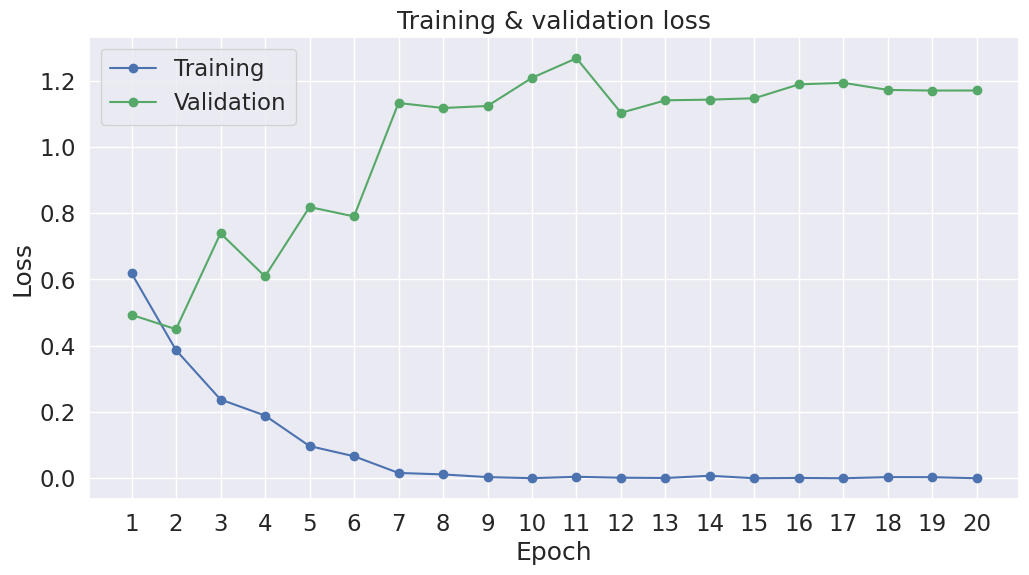

In [19]:
# Plot training and validation loss and accuracy

sns.set(style = 'darkgrid')
sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (12, 6)

fig, axes = plt.subplots(1, 2)

# loss
axes[0].plot(df_stats['Training loss'], 'b-o', label = "Training")
axes[0].plot(df_stats['Validation loss'], 'g-o', label = "Validation")
axes[0].set_title("Training & Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_xticks(range(1, epochs + 1))
#axes[0].set_xticks(range(len(df_stats['Training loss'])))
#axes[0].set_xticklabels(range(1, len(df_stats['Training loss']) + 1))

# acc
axes[1].plot(df_stats['Training accuracy'], 'b-o', label = "Training")
axes[1].plot(df_stats['Validation accuracy'], 'g-o', label = "Validation")
axes[1].set_title("Training & Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_xticks(range(1, epochs + 1))
#axes[1].set_xticks(range(len(df_stats['Training accuracy'])))
#axes[1].set_xticklabels(range(1, len(df_stats['Training accuracy']) + 1))

plt.tight_layout()
plt.show()

#plt.plot(df_stats['Training loss'], 'b-o', label = "Training")
#plt.plot(df_stats['Validation loss'], 'g-o', label = "Validation")
#plt.title("Training & validation loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
#plt.xticks(range(1, epochs + 1))
#plt.show()

#plt.plot(df_stats['Training accuracy'], 'b-o', label = "Training")
#plt.plot(df_stats['Validation accuracy'], 'g-o', label = "Validation")
#plt.title("Training & validation accuracy")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
#plt.xticks(range(1, epochs + 1))
#plt.show()

## Test

In [96]:
def load_data(file_path):

    df = pd.read_csv(file_path)
    df['Sentiment'] = df['Sentiment'].map({'pos': 1, 'neg': 0})
    
    df['text'] = df['text'].astype(str)
    text = df['text'].tolist()
    labels = df['Sentiment'].tolist()

    return text, labels

F_train_text, F_train_labels = load_data("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/all_female_test.csv")
M_train_text, M_train_labels = load_data("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/all_male_test.csv")

# make sure its the right format
print(type(F_train_text))  #  <class 'list'>
print(len(F_train_text))  # 814
print(type(F_train_text[0])) # str

<class 'list'>
814
<class 'str'>


In [97]:
# Load  tokenizer

tokenizer = AutoTokenizer.from_pretrained("vesteinn/DanskBERT")

#finetuned_model= "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models/BERT_finetuned_original"
#tokenizer = AutoTokenizer.from_pretrained(finetuned_model)

tokenizer

XLMRobertaTokenizerFast(name_or_path='vesteinn/DanskBERT', vocab_size=50005, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50004: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [98]:
def tokenize_data(test_text, tokenizer):

    input_ids = []
    attention_masks = []

    for text in test_text:
        encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 512,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt",
    )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    
    return input_ids, attention_masks

# Tokenize the female and male datasets
F_input_ids, F_attention_masks = tokenize_data(F_train_text, tokenizer)
M_input_ids, M_attention_masks = tokenize_data(M_train_text, tokenizer)

# Convert labels to tensors
F_labels = torch.tensor(F_train_labels)
M_labels = torch.tensor(M_train_labels)

# Verify shapes
print(F_input_ids.shape)  # Should be [814, 512]
print(F_attention_masks.shape)  # Should be [814, 512]
print(F_labels.shape)  # Should be [814]

torch.Size([814, 512])
torch.Size([814, 512])
torch.Size([814])


In [99]:
# Create dataset
F_dataset = TensorDataset(F_input_ids, F_attention_masks, F_labels)
M_dataset = TensorDataset(M_input_ids, M_attention_masks, M_labels)

batch_size = 8  # 16, 32

F_dataloader = DataLoader(F_dataset, batch_size = batch_size, shuffle = True)
M_dataloader = DataLoader(M_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
# Load pretrained or fine-tuned  BERT

pretrained_model = AutoModelForSequenceClassification.from_pretrained("vesteinn/DanskBERT", num_labels = 2)
pretrained_model.to(device)

#finetuned_model = "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models" # BERT_finetuned_original
#finetuned_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model)
#finetuned_model.to(device)

In [104]:
def test_model(model, dataloader):

    model.eval()

    predictions = []
    true_labels = []

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask = b_input_mask)
            logits = outputs.logits

        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim = 1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    return metrics, predictions

In [89]:
F_metrics, F_predictions = test_model(pretrained_model, F_dataloader)

print(F_metrics)

{'accuracy': 0.7, 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1_score': np.float64(0.0)}


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [90]:
M_metrics, M_predictions = test_model(pretrained_model, M_dataloader)

print(M_metrics)

{'accuracy': 0.7, 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1_score': np.float64(0.0)}


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [92]:
def calculate_bias(female_preds, male_preds):

    #female_mean = np.mean(female_preds)
    #male_mean = np.mean(male_preds)
    #bias = male_mean - female_mean

    bias = np.mean(np.array(female_preds) - np.array(male_preds))

    return bias

pretrained_bias = calculate_bias(F_predictions, M_predictions)
print(f"Pretrained model bias (Male - Female): {pretrained_bias}")

Pretrained model bias (Male - Female): 0.0
